In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
retail = pd.read_csv('Online+Retail.csv', sep = ",", encoding= "ISO-8859-1", header= 0)
retail.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
retail.shape

(541909, 8)

In [4]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


- CustomerID and Description seems to be having some missing values

In [5]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
retail[retail['Quantity'] == 80995]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,09-12-2011 09:15,2.08,16446.0,United Kingdom


In [7]:
retail[retail['Quantity'] == -80995]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,09-12-2011 09:27,2.08,16446.0,United Kingdom


In [8]:
retail[retail['UnitPrice'] == 38970]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222681,C556445,M,Manual,-1,10-06-2011 15:31,38970.0,15098.0,United Kingdom


In [9]:
retail[retail['UnitPrice'] == -11062.060000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,12-08-2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,12-08-2011 14:52,-11062.06,NaN,United Kingdom


In [10]:
round(100*(retail.isnull().sum())/len(retail),2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

- You usually drop the column when the number of missing values are too high, but in our case the segmentation would be performed on the CustomerID, so we cannot drop the column, instead we will drop the rows

In [11]:
# drop all rows having missing values
retail = retail.dropna()

In [12]:
retail.shape

(406829, 8)

In [13]:
round(100*(retail.isnull().sum())/len(retail),2)

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

### Prepare the data for modeling

- R (Recency): number of days since last purchase
- F (Frequency): number of transactions
- M (Monetary): total amount of transactions

Other types of behavioural segmentation

- R (Relationship): Past interaction with the company
- P (Persona): Type of person
- I (Intent): Intention at the time of purchase


- CDJ (Customer Decision Journey): Based on the customer's life journey with brand or product

Final dataset would have CustID, R, F, M

In [14]:
retail["Amount"] = retail['Quantity']*retail['UnitPrice']
retail.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [15]:
# monetary
retail.groupby('CustomerID')["Amount"].sum()

CustomerID
12346.0       0.00
12347.0    4310.00
12348.0    1797.24
12349.0    1757.55
12350.0     334.40
            ...   
18280.0     180.60
18281.0      80.82
18282.0     176.60
18283.0    2094.88
18287.0    1837.28
Name: Amount, Length: 4372, dtype: float64

In [16]:
grouped_df = retail.groupby('CustomerID')["Amount"].sum()
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [17]:
grouped_df.shape

(4372, 2)

In [18]:
# Frequency
retail.groupby('CustomerID')['Quantity'].sum()

CustomerID
12346.0       0
12347.0    2458
12348.0    2341
12349.0     631
12350.0     197
           ... 
18280.0      45
18281.0      54
18282.0      98
18283.0    1397
18287.0    1586
Name: Quantity, Length: 4372, dtype: int64

In [19]:
frequency = retail.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ["CustomerID", "Frequency"]
frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [20]:
frequency.shape

(4372, 2)

In [21]:
# merge the dataframes

grouped_df = pd.merge(grouped_df, frequency, on = "CustomerID", how = "inner")
grouped_df.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [22]:
# recency

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],
                                    format="%d-%m-%Y %H:%M")
retail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   Amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [23]:
max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [24]:
min_date = min(retail['InvoiceDate'])
min_date

Timestamp('2010-12-01 08:26:00')

In [25]:
# compute the diff -> difference between max date and recent transaction date
retail['diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [26]:
# recency will be the min of all the diff for a particular customer
last_purchase = retail.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [27]:
# merge the dataframes

grouped_df = pd.merge(grouped_df, last_purchase, on = "CustomerID", how = "inner")
grouped_df.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
grouped_df.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [28]:
# number of days only in the recency column
grouped_df['Recency'] = grouped_df['Recency'].dt.days

In [29]:
grouped_df.head(5)

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Text(0.5, 1.0, 'Boxplot of Recency')

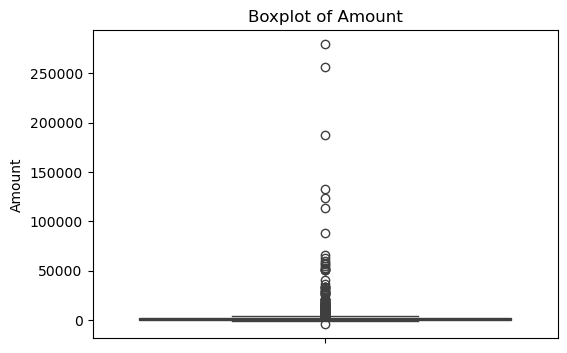

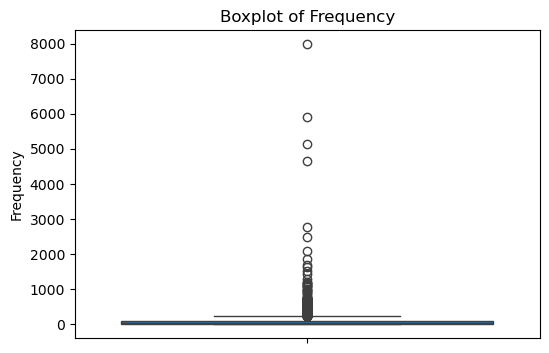

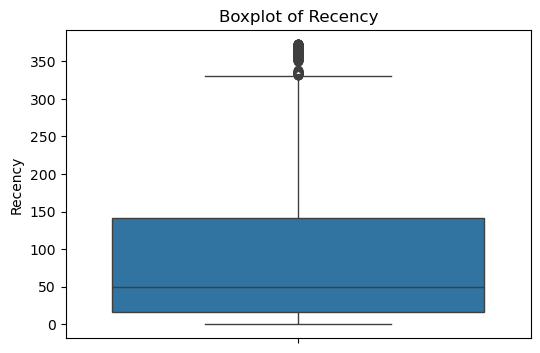

In [30]:
# 1. outlier treatment
plt.figure(figsize=(6, 4)) # Size for the first boxplot
sns.boxplot(grouped_df['Amount'])
plt.title('Boxplot of Amount')

# Create a new figure for the second boxplot
plt.figure(figsize=(6, 4)) # Size for the second boxplot
sns.boxplot(grouped_df['Frequency'])
plt.title('Boxplot of Frequency')

# Create a new figure for the third boxplot
plt.figure(figsize=(6, 4)) # Size for the third boxplot
sns.boxplot(grouped_df['Recency'])
plt.title('Boxplot of Recency')

- Removal of outliers depends on a purely business context. As we are not really sure, if the outliers should be discarded, we will leave them as it is

#### Removing outliers after performing the entire process

In [31]:
# Will re-run the entire code again
Q1 = grouped_df.Amount.quantile(0.05)
Q3 = grouped_df.Amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.Amount >= Q1 - 1.5*IQR)&(grouped_df.Amount <= Q3 + 1.5*IQR)]

Q1 = grouped_df.Frequency.quantile(0.05)
Q3 = grouped_df.Frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.Frequency >= Q1 - 1.5*IQR)&(grouped_df.Frequency <= Q3 + 1.5*IQR)]

Q1 = grouped_df.Recency.quantile(0.05)
Q3 = grouped_df.Recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.Recency >= Q1 - 1.5*IQR)&(grouped_df.Recency <= Q3 + 1.5*IQR)]



In [32]:
# 2. rescaling the variables
rfm_df = grouped_df[['Frequency', 'Amount', 'Recency']]
rfm_df.head(2)

,Frequency,Amount,Recency
0,2,0.0,325
1,182,4310.0,1


In [33]:
scaler = StandardScaler()

rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled

array([[-0.75288754, -0.72373821,  2.30161144],
       [ 1.04246665,  1.73161722, -0.90646561],
       [-0.46363604,  0.30012791, -0.18365813],
       ...,
       [-0.70301659, -0.67769602,  0.86589794],
       [-0.64317145, -0.6231313 , -0.84705678],
       [-0.07464263,  0.32293822, -0.50050524]])

### Hopkins Statistic 
##### To check if the data can be clustered at all or not

The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [34]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [35]:
#First convert the numpy array that you have to a dataframe
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']

In [36]:
#Use the Hopkins Statistic function by passing the above dataframe as a paramter
hopkins(rfm_df_scaled)

0.9577752990493925

### Modeling

In [37]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [38]:
rfm_df_scaled.shape

(4293, 3)

In [39]:
len(kmeans.labels_)

4293

In [40]:
kmeans.labels_

array([1, 0, 3, ..., 1, 3, 3], dtype=int32)

### Finding the optimal number of clusters

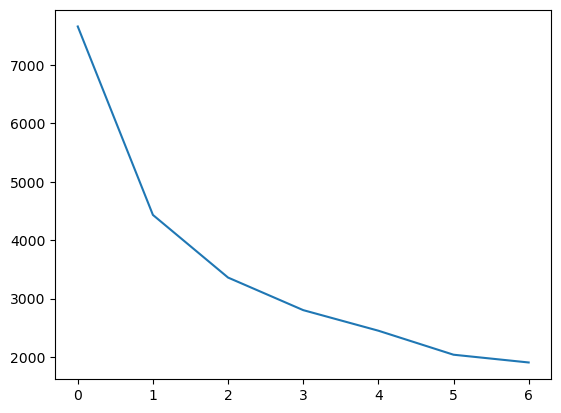

In [41]:
# elbow-curve/SSD(sum of squared distances)

ssd = []
num_of_clusters = [2,3,4,5,6,7,8]
for num_clusters in num_of_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    ssd.append(kmeans.inertia_)

plt.plot(ssd)
# the 0 on the x-axis corresponds to the 2 cluster, 1 corresponds to the 3 cluster ....so on

Look at the graph where the elbow is formed -> this is the point where the number of clusters can be defined. 

- Why so?

If you keep increasing the number of clusters, the intertia is obviously going to keep decreasing, but we need to find where the drop is significant to justify the number of clusters

In [42]:
ssd

[7661.952942045107,
 4433.74768934762,
 3360.719102577021,
 2803.033248739618,
 2450.4904621652418,
 2039.2893421015083,
 1906.298548543831]

In [43]:
# Silhouette Analysis

''' 
score = p-q/max(p,q)

p is the mean distance to the points in the nearest cluster that the data point is not a part of
q is the mean intra-cluster distance to all the points in its own cluster

The value of score ranges from -1 to 1
A score closer to 1 indicates the data point is very similar to the other data points in its own cluster
A score closer to -1 indicates the point is not similar to the data points in its own cluster
'''

' \nscore = p-q/max(p,q)\n\np is the mean distance to the points in the nearest cluster that the data point is not a part of\nq is the mean intra-cluster distance to all the points in its own cluster\n\nThe value of score ranges from -1 to 1\nA score closer to 1 indicates the data point is very similar to the other data points in its own cluster\nA score closer to -1 indicates the point is not similar to the data points in its own cluster\n'

In [44]:

num_of_clusters = [2,3,4,5,6,7,8]
for num_clusters in num_of_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    cluster_labels = kmeans.labels_

    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n clusters = {0}, the score is {1}".format(num_clusters, silhouette_avg))

For n clusters = 2, the score is 0.4025940739563748
For n clusters = 3, the score is 0.5084896296141937
For n clusters = 4, the score is 0.48506020563508856
For n clusters = 5, the score is 0.4143574854128909
For n clusters = 6, the score is 0.41698547252648926
For n clusters = 7, the score is 0.41481670613813887
For n clusters = 8, the score is 0.3892379143220022


- Now again, the score will boil down to the business requirements

In [45]:
# final model with k = 3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [46]:
grouped_df['Cluster_ID'] = kmeans.labels_
grouped_df.head(5)

,CustomerID,Amount,Frequency,Recency,Cluster_ID
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


<Axes: xlabel='Cluster_ID', ylabel='Amount'>

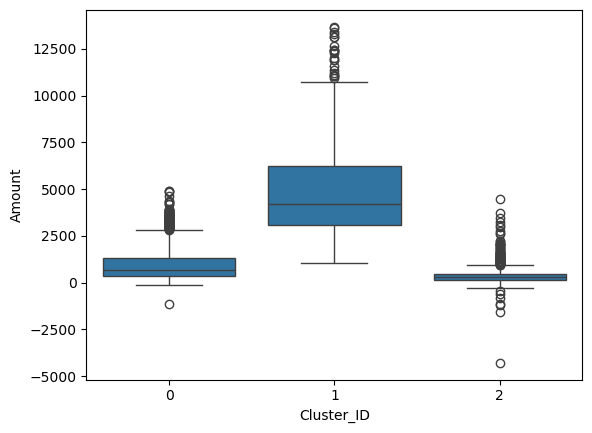

In [47]:
sns.boxplot(x='Cluster_ID', y='Amount', data=grouped_df)

<Axes: xlabel='Cluster_ID', ylabel='Recency'>

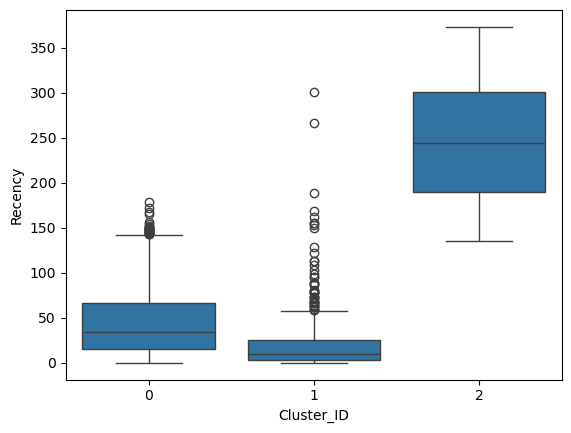

In [48]:
sns.boxplot(x='Cluster_ID', y='Recency', data=grouped_df)

<Axes: xlabel='Cluster_ID', ylabel='Frequency'>

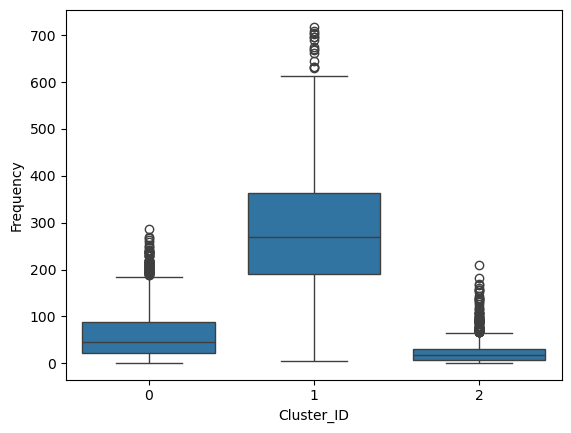

In [49]:
sns.boxplot(x='Cluster_ID', y='Frequency', data=grouped_df)